# Qini-кривая

## Пример

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [2]:
from metrics import qini_df

### Шаг 1: Сбор данных

Предположим, у вас есть данные для 100 пользователей:
- 50 пользователей получили рекламное предложение (группа воздействия).
- 50 пользователей не получили предложение (контрольная группа).

In [3]:
# генерация данных для 100 пользователей

np.random.seed(42)
n = 100
treatment = np.array([1]*50 + [0]*50)
outcome = np.concatenate([np.random.choice([1, 0], p=[0.2, 0.8], size=50),
                          np.random.choice([1, 0], p=[0.1, 0.9], size=50)])
uplift_prediction = np.random.rand(n)

In [4]:
# создание DataFrame

data = {
    'user_id': range(1, n+1),
    'treatment': treatment,
    'outcome': outcome,
    'uplift_prediction': uplift_prediction
}

In [5]:
df = pd.DataFrame(data)
df.head()

,user_id,treatment,outcome,uplift_prediction
0,1,1,0,0.031429
1,2,1,0,0.636410
2,3,1,0,0.314356
3,4,1,0,0.508571
4,5,1,1,0.907566


### Шаг 2: Сортировка данных по uplift_prediction

In [6]:
# сортировка данных по uplift_prediction

df = df.sort_values(by='uplift_prediction', ascending=False).reset_index(drop=True)

In [7]:
df.head()

,user_id,treatment,outcome,uplift_prediction
0,55,0,0,0.985650
1,40,1,0,0.971782
2,41,1,1,0.962447
3,35,1,0,0.942910
4,79,0,0,0.936730


### Шаг 3: Инициализация переменных для расчёта CGain и Random

In [8]:
# инициализация переменных

nt = 0
nt_1 = 0
nc = 0
nc_1 = 0
cgain = []
random = []
optimum = []
incremental_purchases = 0

opt_incremental_purchases = (df["treatment"] * df["outcome"]).sum()
negative_incremental_purchases = ((1 - df["treatment"]) * df["outcome"]).sum()

### Шаг 4: Расчёт CGain, Random и Optimum

In [9]:
# расчёт CGain, Random и Optimum

for i, row in df.iterrows():
    if row['outcome'] == 1:
        if row['treatment'] == 1:
            incremental_purchases += 1
        else:
            incremental_purchases -= 1

    cgain.append(incremental_purchases)

    random.append((opt_incremental_purchases - negative_incremental_purchases) * i / len(df))
    optimum.append(min(opt_incremental_purchases, i) + min(0, len(df) - i - negative_incremental_purchases - 1))

### Шаг 5: Расчёт метрик

In [10]:
# расчёт площади под кривыми

qini_auc = auc(range(1, len(cgain) + 1), cgain)
random_auc = auc(range(1, len(random) + 1), random)

In [11]:
qini_auc, random_auc

(475.0, 392.04)

In [12]:
# расчёт Qini Score

qini_score = qini_auc - random_auc

In [13]:
# вывод Qini Score

print(f'Qini Score: {qini_score}') 

Qini Score: 82.95999999999998


In [14]:
# вывод Optimum Qini Score

print(f'Optimum Qini Score: {auc(range(1, len(optimum) + 1), optimum) - random_auc}') 

Optimum Qini Score: 955.96


### Шаг 6: Построение графика

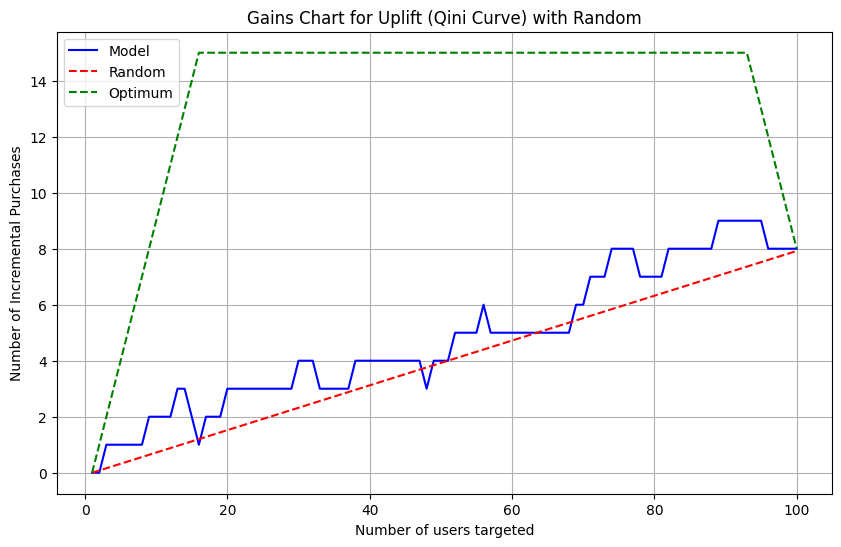

In [15]:
# построение графиков

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cgain) + 1), cgain, label='Model', color='blue')
plt.plot(range(1, len(random) + 1), random, label='Random', color='red', linestyle='--')
plt.plot(range(1, len(optimum) + 1), optimum, label='Optimum', color='green', linestyle='--')
plt.xlabel('Number of users targeted')
plt.ylabel('Number of Incremental Purchases')
plt.title('Gains Chart for Uplift (Qini Curve) with Random')
plt.legend()
plt.grid(True)
plt.show() 

## Задание

Ниже приведён код для отрисовки Qini-кривой. Дополните его и посчитайте Qini Score (площадь под кривой).

Данные можете взять отсюда: https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv.

Правильное решение:

https://www.kaggle.com/code/davinwijaya/uplift-modeling-qini-curve-with-python


In [16]:
# загружаем DataFrame

discount = pd.read_csv("discountuplift.csv", sep="\t")

In [17]:
discount.shape

(12784, 18)

In [18]:
discount.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
0,3,977.51,1,1,1,0,0,0,1,0,0,1,0.476095,0.159710,0.280660,0.083534,-0.043654,0
1,4,391.10,1,0,0,0,1,0,0,1,0,0,0.443035,0.087289,0.285081,0.184594,0.456858,0
2,7,72.37,1,0,1,1,0,0,1,0,0,1,0.514386,0.015488,0.429174,0.040952,0.115756,2
3,10,67.40,1,0,0,1,0,0,1,0,0,1,0.386800,0.125233,0.415839,0.072128,-0.193534,2
4,2,45.68,1,0,1,1,0,0,1,0,1,0,0.517491,0.022507,0.412372,0.047630,0.123726,2


В данном датасете нас интересуют 2 колонки: `uplift_score` и `target_class`.

Расшифровка `target_class`:

- `0` — контрольная выборка, не купили товар ($y_c=0$, в наших терминах)
- `1` — контрольная выборка, купили товар ($y_c=1$, в наших терминах)
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$, в наших терминах);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$, в наших терминах).

In [19]:
discount[["uplift_score", "target_class"]].head(10)

,uplift_score,target_class
0,-0.043654,0
1,0.456858,0
2,0.115756,2
3,-0.193534,2
4,0.123726,2
5,0.174031,2
6,0.082866,0
7,0.094644,3
8,0.060042,0
9,0.002335,0


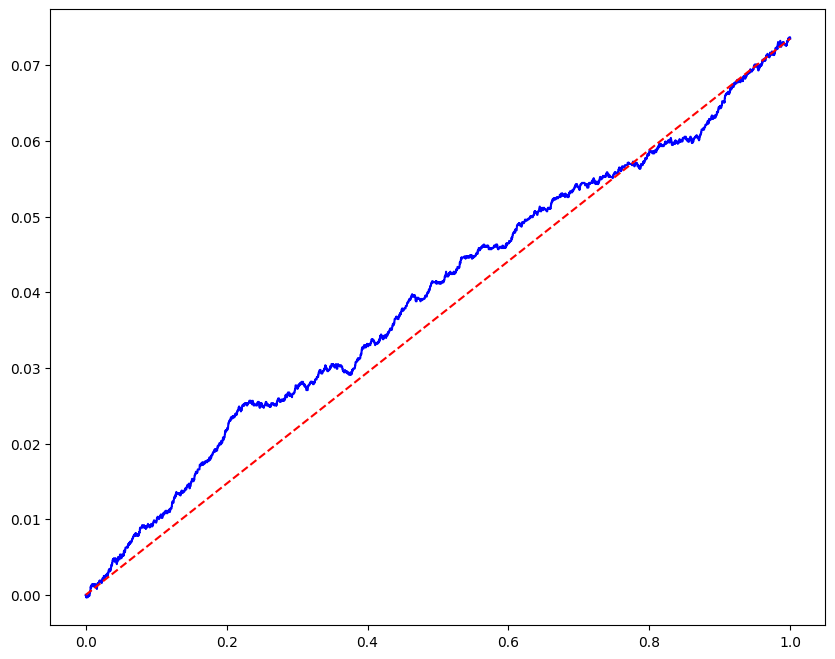

0.0026014823267630632

In [20]:
qini_df(discount)

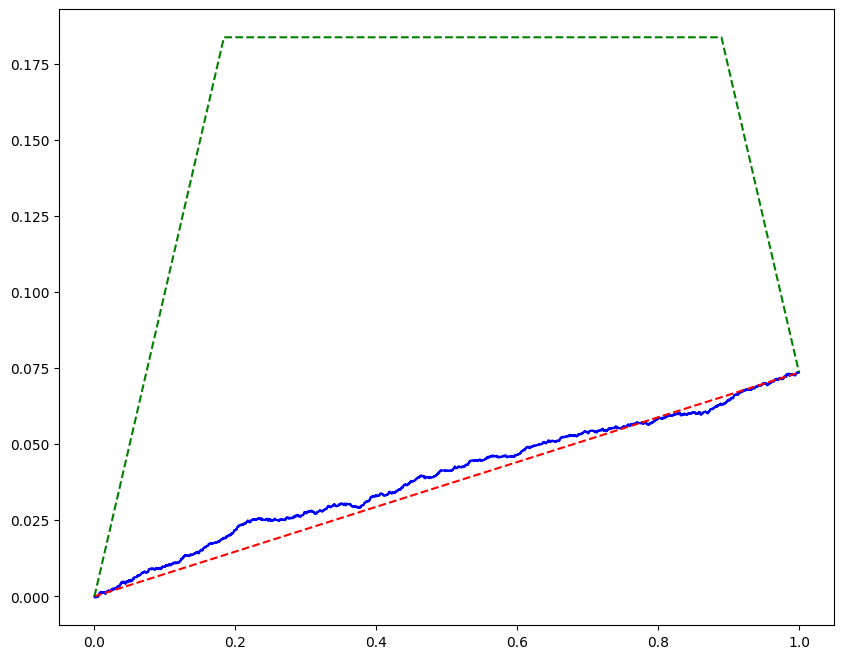

0.0026014823267630632

In [21]:
qini_df(discount, print_optimum=True)

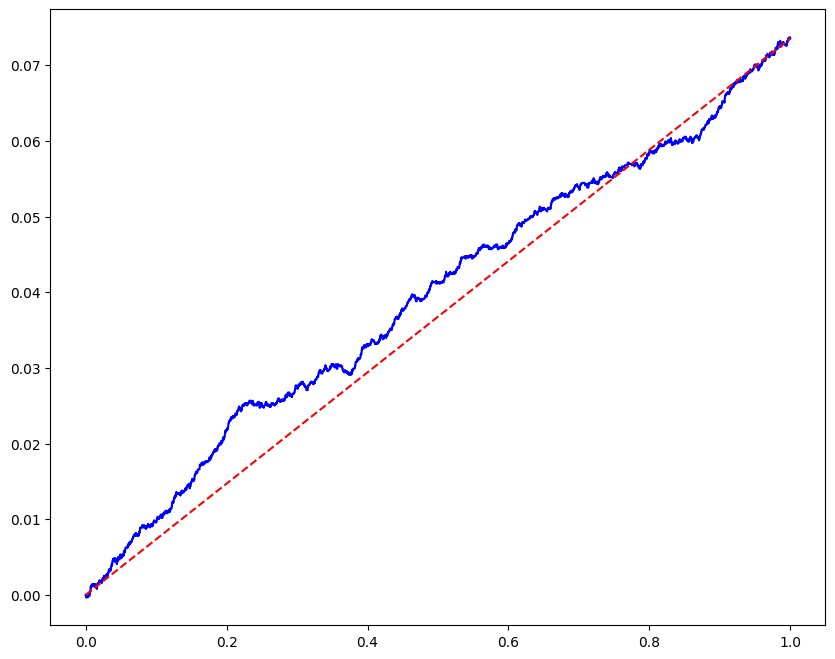

0.0025965886083964065

In [22]:
qini_df(pd.concat([discount] * 10))

## Проверка

In [23]:
df.head()

,user_id,treatment,outcome,uplift_prediction
0,55,0,0,0.985650
1,40,1,0,0.971782
2,41,1,1,0.962447
3,35,1,0,0.942910
4,79,0,0,0.936730


In [24]:
# Преобразуем датафрейм `df` к виду датафрейма `discount`

df["uplift_score"] = df["uplift_prediction"]
df["target_class"] = df["treatment"] * 2 + df["outcome"]

In [25]:
df.head()

,user_id,treatment,outcome,uplift_prediction,uplift_score,target_class
0,55,0,0,0.985650,0.985650,0
1,40,1,0,0.971782,0.971782,2
2,41,1,1,0.962447,0.962447,3
3,35,1,0,0.942910,0.942910,2
4,79,0,0,0.936730,0.936730,0


В данном датасете нас интересуют 2 колонки: `uplift_score` и `target_class`.

Расшифровка `target_class`:

- `0` — контрольная выборка, не купили товар ($y_c=0$, в наших терминах)
- `1` — контрольная выборка, купили товар ($y_c=1$, в наших терминах)
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$, в наших терминах);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$, в наших терминах).

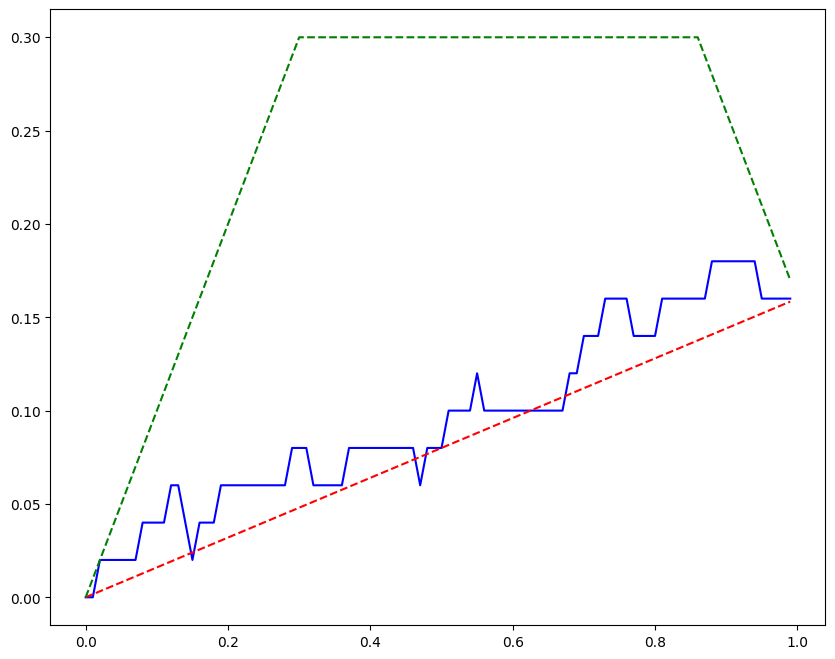

0.01659200000000001

In [26]:
qini_df(df, print_optimum=True)